In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


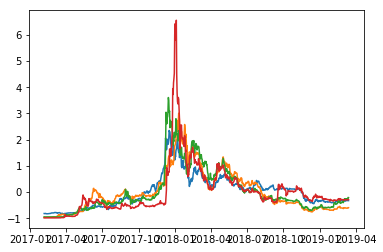

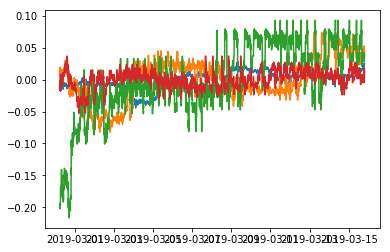

In [2]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

data = prep_data('data.p')
viz_data(data)
data_min = reduce_data(prep_data('data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

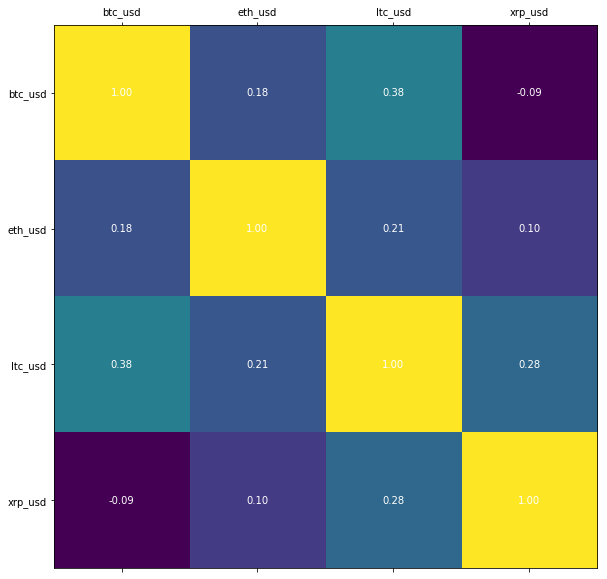

In [3]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [4]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd

def market_risk(pca, balances):
    '''Determines how much our P/L can change given 1-stddev movements along the pca components.
    sqrt(sum_pca(abs(sum_currency(position(currency)^2 * var(pc1) * pc1[currency]))))'''
    balances = pd.DataFrame([{(k+'_usd'):v for k,v in balances.items() if k != 'usd'}])
    components = pd.DataFrame(pca.components_, columns = data['prices'].columns)
    component_variances = components.mul(pca.explained_variance_, axis=0)
    pca_position_variances = component_variances.values.dot((balances * balances.abs()).values.T)
    risk = np.sqrt(np.abs(pca_position_variances).sum())
    return risk + 1e-10 # avoid div by 0

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day
    TODO: separate hedger from strategy?'''
    balances = dict.fromkeys(data_currencies(data), 0)
    dates = []
    pnls = []
    balances_ = []
    balance_values = []
    risks = []
    price_diffs = data['prices'].diff().iloc[1:]
    diff_pca = PCA(n_components=0.997)
    diff_pca.fit(price_diffs)
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]
        orders = strategy.step(balances, prices, volumes)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        dates.append(date)
        balances_.append(balances.copy())
        balance_values.append({ c: qty * price(c) for c, qty in balances.items() })
        pnls.append(current_pnl)
        risks.append(market_risk(diff_pca, balances))
    return {
        'P/L': pd.DataFrame(pnls, index=dates, columns=["P/L"]),
        'balances': pd.DataFrame(balances_, index=dates),
        'balance_values': pd.DataFrame(balance_values, index=dates),
        'risks': pd.DataFrame(risks, index=dates, columns=["Market Risk"])
    }

def return_on_risk(results):
    return results['P/L'].iloc[-1, 0] / results['risks'].values.sum()

def return_on_absolute_positions(results):
    total_absolute_positions = np.abs(results['balance_values'].drop(columns=['usd']).values).sum()
    return results['P/L'].iloc[-1, 0] / (total_absolute_positions + 1) # avoid div by 0

def plot_results(results):
    '''Plots balances (with P/L) and market risk over time for the given strategy results.
    
    Note: RoRs are per-tick. They are NOT comparable across time scales.'''
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    results['balance_values'].plot(ax=axs[0])
    results['P/L'].plot(ax=axs[0])
    results['risks'].plot(ax=axs[1])
    axs[1].axhline(0, color='grey')
    plt.show()
    print('Return on market risk:        {0}'.format(return_on_risk(results)))
    print('Return on absolute positions: {0}'.format(return_on_absolute_positions(results)))
    print('Final P/L:                    {0}'.format(results['P/L'].iloc[-1, 0]))
    print('Final balances:')
    print(results['balances'].iloc[-1])

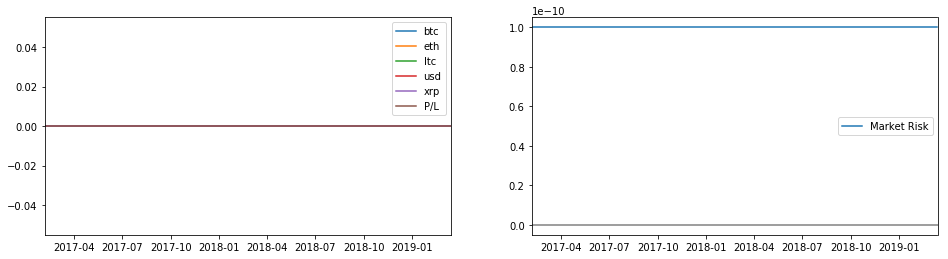

Return on market risk:        0.0
Return on absolute positions: 0.0
Final P/L:                    0.0
Final balances:
btc    0
eth    0
ltc    0
usd    0
xrp    0
Name: 2019-03-14, dtype: int64


In [5]:
from strategy import HoldStrategy

plot_results(evaluate(HoldStrategy(), data))

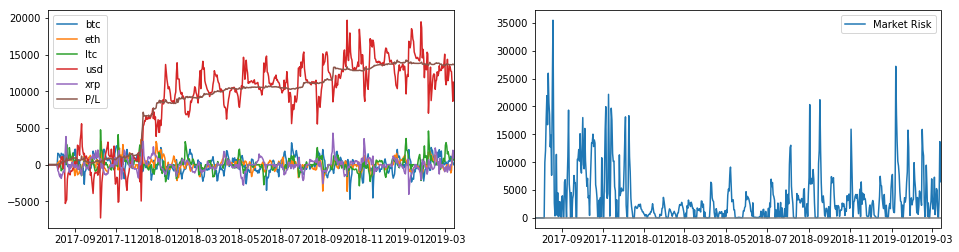

Return on market risk:        0.0061571081087147626
Return on absolute positions: 0.009417057465660714
Final P/L:                    13656.209926784102
Final balances:
btc        0.000000
eth        6.133498
ltc       10.319837
usd    11240.401081
xrp     2908.591944
Name: 2019-03-14, dtype: float64


In [68]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt

class KalmanFilter(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge'''
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.correlation_subsampling = correlation_subsampling
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(movement_half_life)
        
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices, volumes): 
        '''Calculates fair movements by averaging correlated movements between all pairs, weighted by log-volume
        Concretely:
        fair_btc_movement =
            (btc_movment * v_btc
             + eth_movement * v_eth * stddev_btc/stddev_eth
             + ltc_movement * v_ltc * stddev_btc/stddev_ltc
             + xrp_movement * v_xrp * stddev_btc/stddev_xrp
            ) / v_total
        '''
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        
        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return {}
        
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        log_volumes = self.moving_volumes.value.apply(log1p)
        fair_deltas = (predicted_deltas * log_volumes).sum(axis=1) / log_volumes.sum()
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(KalmanFilter(correlation_window_size = 16, movement_half_life = 1, size = 1000, min_edge = 0.25), tail_data(data, 600)))

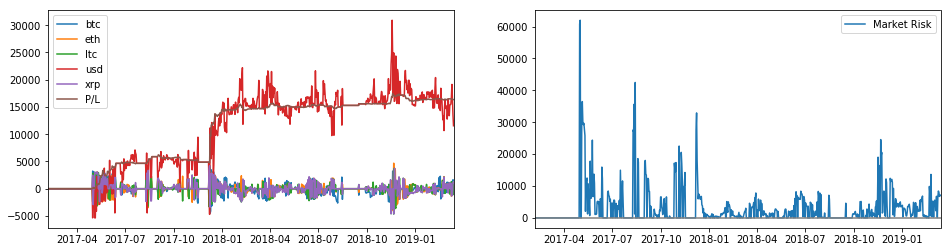

Return on market risk:        0.006825191664055752
Return on absolute positions: 0.009655742512369577
Final P/L:                    16356.067787900589
Final balances:
btc        0.376593
eth        7.994137
ltc       17.572466
usd    11551.650071
xrp     3577.994111
Name: 2019-03-14, dtype: float64


In [71]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt
from johansen.johansen import Johansen
# from scipy.optimize import linprog

def cointegrate(data):
    '''Returns eigenvectors for statistically-significant cointegration relations.
    TODO: return confidences, by using eigenvalues directly.'''
    eigenvectors, r = Johansen(data, model=2, significance_level=0).johansen()
    return np.array(eigenvectors)[r]

def plot_eigenvectors(evs):
    evs /= np.linalg.norm(evs, axis=1, keepdims=True)
    plot_matrix(pd.DataFrame(evs))

class Cointegrater(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge'''
        self.prev_prices = None
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(movement_half_life)
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        
#         self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

#         if not self.moving_prices.ready:
#             return {}
        
        self.moving_prices_history.append(prices)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
        deltas = prices / df.mean() - 1
        
        relations = cointegrate(df)
#         print(relations)
#         print(relations.sum(axis=1, keepdims=True))
        relations /= relations.sum(axis=1, keepdims=True)
        edges = []
        for relation in relations:
            R = np.broadcast_to(relation, (prices.shape[0], prices.shape[0])).copy()
            np.fill_diagonal(R, 0)
            synth_cointegrations = pd.DataFrame(df.values.dot(R), columns = df.columns)
            edges_ = (synth_cointegrations.iloc[-1] - synth_cointegrations.mean()) / synth_cointegrations.std()
            edges.append(edges_)
        if len(edges) > 0:
            edges = pd.Series(np.mean(edges, axis=0), index = df.columns)
        else:
            edges = pd.Series([0,0,0,0], index = df.columns)
#         relations = pd.DataFrame(relations, columns = prices.index)
# #         print(deltas)
# #         print(relations)
# #         print(np.zeros((relations.shape[0], 1)))
# #         res = linprog(c = deltas, A_eq = relations, b_eq = np.zeros((relations.shape[0], 1)))
# #         print(res)
# #         print(relations)
#         C = df.dot(relations.T)
#         edges = (relations.dot(prices) - C.mean()) / C.std()
#         print(edges.mean())
#         mean_ratios = relations * df.mean()
# #         print(ratios)
#         parts = df * relations.iloc[0]
#         part_ratios = parts / C.iloc[:,0].mean()
#         part_ratios.plot()
# #         (prices / df.mean()).plot()
# #         (C / C.mean()).plot()
#         x = relations.dot(deltas)
#         x2 = x * np.abs(x)
#         print(x)
#         print(x2)
#         print(x / C.mean() - 1)
#         print(deltas)
#         D = np.broadcast_to(deltas.values, relations.shape).copy()
#         np.fill_diagonal(D, 0)
#         implied_deltas = (relations / np.diag(relations)).dot(D.T)
#         print(implied_deltas)
#         (C / C.mean() - 1).plot()
#         edges = {}
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(Cointegrater(correlation_window_size = 64, movement_half_life = 1, size = 1000, min_edge = 0), tail_data(data, 1000)))

In [ ]:
plot_results(evaluate(StatArb(correlation_window_size = 32, movement_half_life = 1, size = 1000, min_edge = 0.25), data_15min))

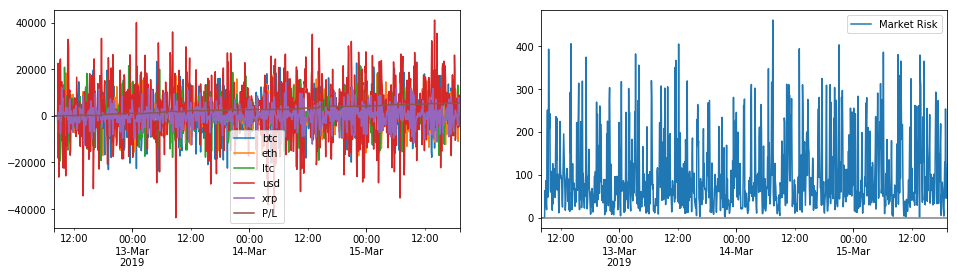

Return on market risk:        0.05578300821204998
Return on absolute positions: 0.00033357709624510617
Final P/L:                    5587.255701125241
Final balances:
btc       0.119047
eth      -4.967047
ltc     -66.450250
usd    8261.515556
xrp    4645.940941
Name: 2019-03-15 19:10:00, dtype: float64


In [81]:
plot_results(evaluate(StatArb(correlation_window_size = 4, movement_half_life = 8, size = 1000, min_edge = 0.25), tail_data(data_5min, 1000)))

btc_usd   -0.693899
eth_usd    0.213007
ltc_usd    0.179307
xrp_usd   -0.112715
dtype: float64
btc_usd   -0.673864
eth_usd    0.761872
ltc_usd   -0.438696
xrp_usd   -0.696921
dtype: float64
btc_usd   -0.602609
eth_usd   -0.585938
ltc_usd    0.279568
xrp_usd   -0.517923
dtype: float64
btc_usd   -0.522037
eth_usd   -0.503381
ltc_usd    0.148382
xrp_usd   -0.398604
dtype: float64
btc_usd   -0.263301
eth_usd    0.502497
ltc_usd   -0.188293
xrp_usd   -0.382243
dtype: float64
btc_usd   -0.089536
eth_usd    0.467477
ltc_usd   -0.107478
xrp_usd   -0.300206
dtype: float64
btc_usd   -0.197771
eth_usd    0.493591
ltc_usd   -0.117873
xrp_usd   -0.332613
dtype: float64
btc_usd   -0.803088
eth_usd    0.532304
ltc_usd   -0.247209
xrp_usd    0.496936
dtype: float64
btc_usd   -0.820846
eth_usd    0.138781
ltc_usd    0.111642
xrp_usd   -0.122317
dtype: float64
btc_usd    2.303713e-14
eth_usd   -2.823436e-14
ltc_usd    6.601664e-14
xrp_usd    9.793555e-14
dtype: float64
btc_usd   -0.888367
eth_usd    0.1

btc_usd    3.885781e-16
eth_usd    4.337825e-01
ltc_usd   -7.349676e-14
xrp_usd    4.458410e-01
dtype: float64
btc_usd   -0.151946
eth_usd    0.746207
ltc_usd    0.765566
xrp_usd    0.250161
dtype: float64
btc_usd    3.709111e-01
eth_usd    1.188494e-13
ltc_usd    7.751050e-01
xrp_usd    4.096723e-14
dtype: float64
btc_usd    2.420286e-14
eth_usd    6.883366e-01
ltc_usd    7.930793e-01
xrp_usd    7.297024e-01
dtype: float64
btc_usd    1.326717e-14
eth_usd    7.293197e-01
ltc_usd    7.928523e-01
xrp_usd    7.758084e-01
dtype: float64
btc_usd    1.465494e-14
eth_usd    7.230762e-01
ltc_usd   -5.223599e-14
xrp_usd    7.661501e-01
dtype: float64
btc_usd   -0.669173
eth_usd    0.717530
ltc_usd    0.774586
xrp_usd    0.762524
dtype: float64
btc_usd    0.934265
eth_usd   -0.735460
ltc_usd    0.803240
xrp_usd   -0.813468
dtype: float64
btc_usd   -0.950124
eth_usd   -0.728035
ltc_usd    0.799229
xrp_usd    0.809339
dtype: float64
btc_usd    0.901441
eth_usd   -0.721022
ltc_usd    0.778503
xrp_u

btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0

btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0.012100
eth_usd    3.496288
ltc_usd   -3.375079
xrp_usd    3.465465
dtype: float64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0
eth_usd    0
ltc_usd    0
xrp_usd    0
dtype: int64
btc_usd    0.019799
eth_usd    3.529646
ltc_usd   -3.407533
xrp_usd   -3.477159
dtype: float64
btc_usd   -0.153171
eth_usd    3.328364
ltc_usd   -3.228870
xrp_usd    3.274442
dtype: float64


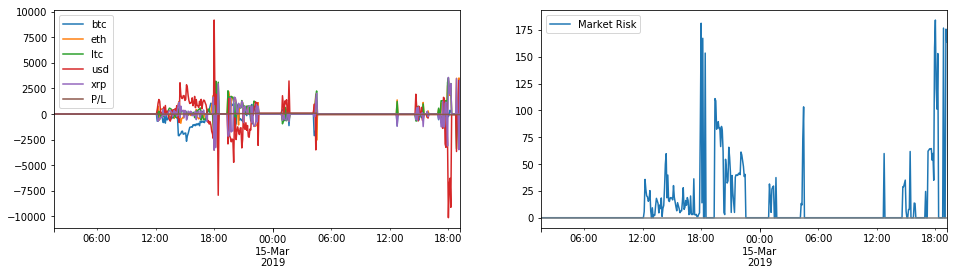

Return on market risk:        -0.0077217654397971226
Return on absolute positions: -9.995474353849458e-05
Final P/L:                    -45.51133438539091
Final balances:
btc       -0.038942
eth       23.866422
ltc      -54.697866
usd    -3266.276696
xrp    10296.988914
Name: 2019-03-15 19:10:00, dtype: float64


In [54]:
plot_results(evaluate(Cointegrater(correlation_window_size = 128, movement_half_life = 1, size = 1000, min_edge = 0), tail_data(data_5min, 500)))

Trying window_size: 4 and half_life: 36.15977708580905
  RoR: 0.002265728051529942
Trying window_size: 4 and half_life: 66.02408083773594
  RoR: 0.004538185483346184
Trying window_size: 5 and half_life: 31.130653353004817
  RoR: 0.002208708150815142
Trying window_size: 5 and half_life: 36.80001863887392
  RoR: 0.005856131630058562
Trying window_size: 5 and half_life: 67.71885057077685
  RoR: 0.003523806206202591
Trying window_size: 5 and half_life: 33.89336812886329
  RoR: 0.003758599102393558
Trying window_size: 4 and half_life: 25.284324835438063
  RoR: -0.0018621198902417345
Trying window_size: 4 and half_life: 22.627660525008867
  RoR: -0.002149229163434422
Trying window_size: 6 and half_life: 54.073952580270024
  RoR: 0.0030357904333170537
Trying window_size: 4 and half_life: 27.97719857122574
  RoR: 0.0007806512519817738
Trying window_size: 4 and half_life: 91.03235792245862
  RoR: 0.0021735157546419227
Trying window_size: 4 and half_life: 45.41933194496844
  RoR: 0.0028860364783

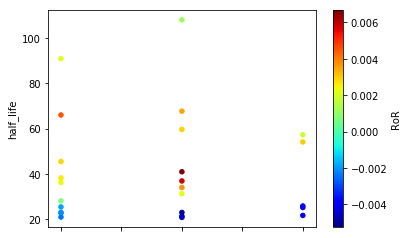

In [74]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 20 + 20
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.uniform(4, 7))
#         window_size = 4
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = evaluate(StatArb(window_size, movement_half_life, size=1000, min_edge=0.25), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_5min, 600), 25)